In [2]:
import numpy as np
import scipy as sp
from scipy.linalg import toeplitz
import matplotlib.pyplot as plt
from time import time as timer
import Branching_Process as bp
import pandas as pd
from tqdm import tqdm
import importlib
import seaborn as sns

#sns.set_palette()
cmap = sns.color_palette('tab10')
importlib.reload(bp)


<module 'Branching_Process' from '/Users/jacobcurran-sebastian/pgf_disc/Branching_Process.py'>

In [14]:
Tmax = 200
nsteps = 2*Tmax +1 
time = np.linspace(0, Tmax, num=nsteps)
time_step = time[1] - time[0]
R_eff = 3
t_lockdown = 30

eta = 0.2
eta2 = 0.5
# From FF100 data, Challen et al. 2021 Meta-analysis
gmean = 4.87
gsd = 1.98
alpha = gmean**2 / gsd**2
beta = gsd**2 / gmean



def lifetime(t, tau):
    return sp.stats.gamma.cdf(t, a = alpha, scale = beta) # sp.stats.expon.cdf(t, scale = 1/gamma_test)

def lifetime_pdf(t, tau):
    return sp.stats.gamma.pdf(t, a = alpha, scale = beta)


def infectiousness(t):
    return sp.stats.gamma.cdf(t, a = alpha, scale = beta)

def infectiousness_pdf(t):
    return sp.stats.gamma.pdf(t, a = alpha, scale = beta)

def poisson_offspring(z, lamb = 1):
    return lamb*(z-1)

def R_constant(t, R=R_eff):
    return R



# Constant immigration
def scenario_1_im(t): 
    return eta*np.ones_like(t)

# Constant immigration (lower rate)
def scenario_2_im(t):
    return eta2 * np.ones_like(t)

# Exp increasing immigration
def scenario_3_im(t):
    return eta * np.exp(0.02*t)

# Exp decreasing immigration
def scenario_4_im(t):
    return eta * np.exp(-0.02*t)


# Total shutdown scenario
def scenario_5_im(t, t_stop = 15):
    return eta * (t < t_stop)


# Two exogenous sources - one growing epidemic, tighter controls + one decreasing epidemic, looser controls
def scenario_6_im(t, eta_country1 = 0.05, eta_country2 = -0.02, control_country1=0.01, control_country2 = 0.2):
    return control_country1*np.exp(eta_country1*t) + control_country2*np.exp(eta_country2*t)


def intensity_measure(t):
    return R_constant(t) * infectiousness_pdf(t) * (1-lifetime(t, 0))

#lifespan_average = np.linspace(0, a/b)

R0_true = sp.integrate.quad(intensity_measure, 0, 100)[0]

print('R0 is: ' + str(R0_true))

immigration_scenarios = [scenario_1_im, scenario_2_im, scenario_3_im, scenario_4_im, scenario_5_im, scenario_6_im]
immigration_scenario_labels = ["scenario_1", "scenario_2", "scenario_3", "scenario_4", "scenario_5", "scenario_6"]


R0 is: 1.5000000000000147


In [40]:
immigration_scenarios = [scenario_1_im, scenario_2_im, scenario_3_im, scenario_4_im, scenario_5_im, scenario_6_im]
immigration_scenario_labels = ["scenario_1", "scenario_2", "scenario_3", "scenario_4", "scenario_5", "scenario_6"]


max_pgf = 20000

n_cores = 6
characteristic = 'prev'
scenarios = []
pmf_scenarios = []

for i, immigration in enumerate(immigration_scenarios):
    if i != 5:
        continue
    cmj_immigration = bp.cmj(poisson_offspring, time=time)
    cmj_immigration.set_lifetime_distribution(lifetime)
    cmj_immigration.set_infectiousness_profile(infectiousness)
    cmj_immigration.set_transmission_rate(R_constant)
    cmj_immigration.set_immigration(immigration)
    scenarios += [cmj_immigration]
    start = timer()
    pmf_immigration = bp.pmfft(cmj_immigration.pgf_immigration, 
                    max_pgf,
                    immigration = immigration,
                    parallel = True,
                    n_cores = n_cores)
    stop = timer()
    
    print('Scenario ' + str(i) + ' finished in ' + str(np.round(stop - start, 2)) + ' seconds!')

    pmf_scenarios += [pmf_immigration]
    np.savetxt('./Scenarios/Immigration/pmf_immigration' + immigration_scenario_labels[i] + '.csv', pmf_immigration)

Scenario 5 finished in 1851.68 seconds!


In [15]:
pmf_scenarios = []
for i, lab in enumerate(immigration_scenario_labels):
    #np.savetxt('./Scenarios/Immigration/pmf_immigration' + immigration_scenario_labels[i] + '.csv, sc)
    sc = np.genfromtxt('./Scenarios/Immigration/pmf_immigration' + lab + '.csv')
    pmf_scenarios += [sc]


In [16]:
fpt_scenarios = []
n_scenarios = len(pmf_scenarios)
Zstars = np.zeros(len(pmf_scenarios))
tstars = np.zeros(len(pmf_scenarios))
for i in range(n_scenarios):
    pmf = pmf_scenarios[i]
    mean = bp.mean_pmf(pmf)
    extinction = pmf[0, :]
    Zstar = 100
    try:
        tstar_idx = np.argwhere(mean >= Zstar)[1][0]#np.argwhere(np.gradient(extinction, time_step)<= 0.0001)[1][0]
    except:
        tstar_idx = -1
    tstar = time[tstar_idx]
    #int(mean[tstar_idx]) + 1
    Zstars[i] = Zstar
    tstars[i] = tstar
    FPT_cdf = bp.FirstPassageTime(pmf, Zstar, time, False)
    fpt_scenarios += [np.gradient(FPT_cdf, time_step)]

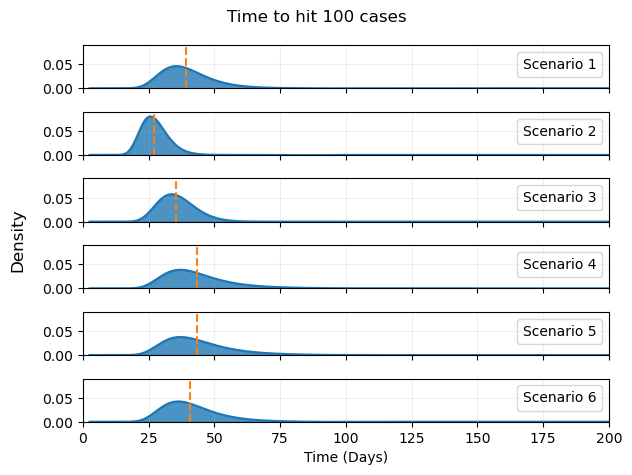

In [18]:
n_scenarios = len(pmf_scenarios)
fig, axs = plt.subplots(nrows = n_scenarios, ncols = 1)
immigration_legend_labels = ['Scenario ' + str(int(i+1)) for i in range(n_scenarios)]
#fig.set_figwidth(6)

for i in range(n_scenarios):
    axs[i].label_outer()
    
    axs[i].plot(time[5:], fpt_scenarios[i][5:], color = cmap[0], label = immigration_legend_labels[i])
    axs[i].fill_between(time[5:], fpt_scenarios[i][5:], color = cmap[0], alpha = 0.8)
    axs[i].axvline(np.sum(time[5:] * fpt_scenarios[i][5:])*time_step, color = cmap[1], linestyle = '--')
    axs[i].grid(alpha = 0.2)
    axs[i].set_xlim([0, 200])
    axs[i].set_ylim([0, 0.09])
    axs[i].legend(handlelength=0, handletextpad=0, fancybox=True)
    #axs[i].set_xlim([0, 100])

plt.xlabel('Time (Days)')
fig.supylabel('Density')
plt.suptitle('Time to hit ' + str(Zstar) + ' cases')
plt.tight_layout() 

# plt.savefig('./Figures/scenarios_fpt_immigration.pdf')
